In [1]:
%matplotlib inline

import system_generation as sysgen
import median_methods as methods
import plots
import math
import numpy as np
import matplotlib.pyplot as plt


For the first few tests we'll use the same Gaussian system.

In [2]:
rows, cols = 50000, 100
beta = 0.2
errs = math.ceil(beta * rows);
A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
start = np.zeros(cols)
start_data = [A,b,start]

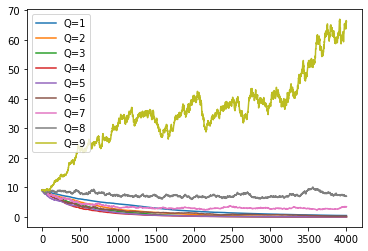

In [3]:
sgd_various_quantiles = [[methods.SampledQuantileSGD(*start_data, 
		quantile=q/10, samples=100),"Q="+str(q)] for q in range(1,10)]
plots.make_plot(sgd_various_quantiles, iters=4000, soln=soln)
plt.show()

In [ ]:
rk_various_quantiles = [[methods.SampledQuantileRK(*start_data, 
		quantile=q/10, samples=100),"Q="+str(q)] for q in range(1,8)]
linedesigns = [
#[linestyle info, linewidth, markersize, markevery] 
['g',2,12,1000],
['b--',2,12,1000],
['r-.',2,12,1000],
['c:',2,12,1000],
['ko-',2,7,1000],
['mv--',2,7,1000],
['br-',2,7,1000]
] 
plots.make_plot(rk_various_quantiles, iters=4000, soln=soln, linedesigns=linedesigns)
plt.show()

ValueError: Illegal format string "br-"; two color symbols

In [ ]:
quantiles = np.linspace(0,0.9,num=100)
sgd_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileSGD(*start_data, quantile = q, samples=100) , 
        iters=4000, soln=soln)) for q in quantiles]
plt.xlabel('Quantile')
plt.ylabel('Error after 4000 iterations')
plt.plot(quantiles, sgd_error_by_quantile)
plt.show()

In [ ]:
quantiles = np.linspace(0,0.9,num=100)
rk_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileRK(*start_data, quantile = q, samples=100) , 
                                     iters=4000, soln=soln)) for q in quantiles]
plt.xlabel('Quantile')
plt.ylabel('Error after 4000 iterations')
plt.plot(quantiles, rk_error_by_quantile)
plt.show()

Note that SGD is much less sensitive to the choice of quantile than is RK.   

---
Here we see a comparison of quantile based RK and quantile SGD.

In [ ]:
rk_vs_sgd = [[methods.SampledQuantileSGD(*start_data, 
		quantile=0.4, samples=100), "q-SGD with q = 0.4"],
		[methods.SampledQuantileRK(*start_data, 
		quantile=0.7, samples=100), "q-RK with q = 0.7"]]
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
linedesigns = [
#[linestyle info, linewidth, markersize, markevery] 
['',2,12,1000],
['o--',2,7,1000],
] 
plots.make_plot(rk_vs_sgd,iters=10000,soln=soln, linedesigns=linedesigns)
plt.show()

---
How does the sliding window method compare to subsampling rows?

In [ ]:
sw_sgd = methods.SW_SGD(*start_data, quantile = 0.4, window_size=100)
sampled_sgd = methods.SampledQuantileSGD(*start_data, quantile = 0.4, samples=100)
plots.make_plot([[sw_sgd, "Sliding Window"], [sampled_sgd,"Subsampled"]], iters=4000, soln=soln)
plt.show()

In [ ]:
sw_rk = methods.SWQuantileRK(*start_data, quantile = 0.7, window_size=100)
sampled_rk = methods.SampledQuantileRK(*start_data, quantile = 0.6, samples=100)
plots.make_plot([[sw_rk, "Sliding Window RK"], [sampled_rk,"Subsampled RK"]], iters=4000, soln=soln)
plt.show()

How do the two methods compare as far as time?

In [ ]:
from timeit import default_timer as timer

iters = 10000

sw_rk = methods.SWQuantileRK(*start_data, quantile = 0.7, window_size=100)
sampled_rk = methods.SampledQuantileRK(*start_data, quantile = 0.6, samples=100)

def time_method(method, iters):
    start = timer()
    for i in range(0,iters):
        method.do_iteration()
    end = timer()
    return end - start

sw_time = time_method(sw_rk,iters)
print("Time for sliding window: ", sw_time)

sampled_time = time_method(sampled_rk,iters)
print("Time for sampled rk: ", sampled_time)
print("sampled/sliding: ", sampled_time/sw_time)
    

---

What happens with SGD when we increase the fraction of corruptions?  By varying $\beta$ we can see how the behavior of SGD changes for various quantiles.

In [ ]:
rows, cols = 50000, 100
start = np.zeros(cols)
linedesign = [
#[linestyle info, linewidth, markersize, markevery] 
['',4,12,2],
['--',2,12,2],
['-.',2,12,2],
[':',2,12,2],
['o-',2,7,2],
['v--',2,7,2],
['-',2,7,2]
] 
for i, beta in enumerate([0,0.1,0.2,0.3,0.4,0.5,0.6]):
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start_data = [A,b,start]
    quantiles = np.linspace(0.1,0.9, num=9)
    sgd_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileSGD(*start_data, quantile = q, samples=100) , 
                                     iters=4000, soln=soln)) for q in quantiles]
    plt.plot(quantiles, sgd_error_by_quantile, linedesign[i][0],  label=r"$\beta$="+str(beta), linewidth=linedesign[i][1], markersize=linedesign[i][2],
                           markevery=linedesign[i][3])

plt.xlabel('Quantile')
plt.ylabel('Error after 4000 iterations')
plt.legend(loc='lower left')
plt.show()

Note that for $\beta$ very small, the median appears to behave best among the quantiles.  As $\beta$ grows large, lower quantiles yield better behavior.

We can run the same experiment for median RK

In [ ]:
rows, cols = 50000, 100
start = np.zeros(cols)

for i, beta in enumerate([0,0.1,0.2,0.3,0.4,0.5,0.6]):
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start_data = [A,b,start]
    quantiles = np.linspace(0.1,0.9, num=9)
    rk_error_by_quantile = [math.log(plots.final_error( methods.SampledQuantileRK(*start_data, quantile = q, samples=100) , 
                                     iters=4000, soln=soln)) for q in quantiles]
    plt.plot(quantiles, rk_error_by_quantile, linedesign[i][0],  label=r"$\beta$="+str(beta), linewidth=linedesign[i][1], markersize=linedesign[i][2],
                           markevery=linedesign[i][3])
plt.ylabel('Error after 4000 iterations')
plt.legend(loc='lower left')
plt.show()

---


Let's see what happens for less tall matrices.

In [ ]:
def tall_test(rows, cols):
    beta = 0.2
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start = np.zeros(cols)
    start_data = [A,b,start]

    rk_vs_sgd = [[methods.SampledQuantileSGD(*start_data, 
    quantile=0.4, samples=100), "SGD"],
    [methods.SampledQuantileRK(*start_data, 
    quantile=0.7, samples=100), "RK"]]
    
    plots.make_plot(rk_vs_sgd,iters=10000,soln=soln)
    plt.show()
    
    

In [ ]:
tall_test(200,100)

In this case, SGD (and to a lesser extent RK) appear to initially converge linearly while eventually reaching a convergence horizon.

In [ ]:
tall_test(500,100)

For slightly taller matrices, SGD and RK seem to avoid the convergence horizon.  These results agree with our theory which suggests that the aspect ratio of the matrix should be a sufficiently large constant.

For SGD, let's see how the aspect ratio of the matrix affects convergence properties.

In [ ]:
beta = 0.2
cols = 100

errors = []
aspects = [2,2.5,3,3.4,4,4.5,5,6]
for aspect in aspects:
    rows = math.floor(aspect*cols)
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start = np.zeros(cols)
    start_data = [A,b,start]

    errors.append(math.log(plots.final_error( methods.SampledQuantileRK(*start_data, quantile = 0.4, samples=100) , 
                                     iters=10000, soln=soln)))
plt.plot(aspects, errors)
plt.show()

---


How well does quantile SGD approximate OPT sgd?

In [ ]:
rows, cols = 5000, 100
beta = 0.2
errs = math.ceil(beta * rows);
A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
start = np.zeros(cols)
start_data = [A,b,start]

opt_sgd = methods.OptSGD(*start_data, soln=soln)
sampled_sgd = methods.SampledQuantileSGD(*start_data, quantile = 0.4, samples=100)
plots.make_plot([[opt_sgd, "Opt SGD"], [sampled_sgd,"Sampled SGD"]], iters=1000, soln=soln)
plt.show()

How does opt_sgd behave for various fractions of errors?

In [ ]:
rows, cols = 1000, 100

for beta in np.linspace(0.1, 0.9, num=9):
    errs = math.ceil(beta * rows);
    A,b,soln = sysgen.normalized_gaussian_with_errors(rows, cols, errs, max_error=1)
    start = np.zeros(cols)
    start_data = [A,b,start]
    opt_sgd = methods.OptSGD(*start_data, soln=soln)
    plots.make_plot([[opt_sgd,"beta="+str(beta)]], iters=1000, soln=soln)
plt.show()